<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/GISAID_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geobr

In [448]:
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import requests
import plotly.graph_objects as go

import time
from tqdm import tqdm

from geobr import read_municipality
import geopandas as gpd
import gc

from statsmodels.tsa.stattools import ccf
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrix
from statsmodels.gam.api import GLMGam, BSplines

from sklearn.preprocessing import StandardScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
sero1 = pd.read_csv('/content/drive/MyDrive/GISAID/Serotype_Progression_sp.csv')
sero2 = pd.read_csv('/content/drive/MyDrive/GISAID/Serotype_Progression_rgs.csv')
sero3 = pd.read_csv('/content/drive/MyDrive/GISAID/Serotype_Progression_mg.csv')

sero1

,variant,yearmth,percentage
0,DENV1,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0.9286,0.9851,0.9173,0.9369,0.9643,0.75,1,1,1,..."
1,DENV2,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0.0714,0.0149,0.0827,0.0631,0.0357,0.25,0,0,0,..."
2,DENV3,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...."
3,DENV4,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [ ]:
voc1 = pd.read_csv('/content/drive/MyDrive/GISAID/VOCVOI_Progression_sp.csv')
voc2 = pd.read_csv('/content/drive/MyDrive/GISAID/VOCVOI_Progression_rgs.csv')
voc3 = pd.read_csv('/content/drive/MyDrive/GISAID/VOCVOI_Progression_mg.csv')

voc1

,genotype,yearmth,percentage
0,DENV1-V,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0.9286,0.9851,0.9173,0.9369,0.9643,0.75,1,1,1,..."
1,DENV2-II,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0.0714,0.0149,0.0376,0.018,0.0179,0.25,0,0,0,0..."
2,DENV3-III,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0...."
3,DENV2-III,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0.0451,0.045,0.0179,0,0,0,0,0,0,0,0.0263,0..."
4,DENV2-Outgroup,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
5,DENV4-II,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
6,DENV1-III,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."
7,DENV1-Outgroup,"2022-01,2022-02,2022-03,2022-04,2022-05,2022-0...","0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,..."


In [ ]:
def reformat(raw, col_info):
  data_df = pd.DataFrame()
  for i in range(len(raw)):
    y = raw["yearmth"][i].split(",")
    p = raw["percentage"][i].split(",")
    df = pd.DataFrame({'var':raw[col_info][i], 'time': y,'percent': p})
    data_df = pd.concat([data_df, df])

    data_df['time'] = pd.to_datetime(data_df['time'])
    data_df['percent'] = pd.to_numeric(data_df['percent'])

  return data_df

In [ ]:
sero_df1 = reformat(sero1, "variant")
sero_df2 = reformat(sero2, "variant")
sero_df3 = reformat(sero3, "variant")
sero_df1.head(3)

,var,time,percent
0,DENV1,2022-01-01,0.9286
1,DENV1,2022-02-01,0.9851
2,DENV1,2022-03-01,0.9173


In [ ]:
sero_df1.tail(3)

,var,time,percent
40,DENV4,2025-05-01,0.0
41,DENV4,2025-06-01,0.0
42,DENV4,2025-07-01,0.0


In [ ]:
voc_df1 = reformat(voc1, "genotype")
voc_df2 = reformat(voc2, "genotype")
voc_df3 = reformat(voc3, "genotype")

voc_df1.head(3)

,var,time,percent
0,DENV1-V,2022-01-01,0.9286
1,DENV1-V,2022-02-01,0.9851
2,DENV1-V,2022-03-01,0.9173


In [ ]:
# def plot_int(df, region):
#   fig = px.area(df, x='time', y='percent', color='var',
#                 labels={'time':'Date', 'percent':'Proportion', 'var':'Serotype'},
#                  title=f'Serotype Progression in {region}')
#   fig.update_layout(yaxis_tickformat='.0%', legend_title_text='')
#   fig.update_xaxes(rangeslider_visible=True, rangeslider=dict(bgcolor='grey'))
#   fig.update_yaxes(range=[0, 1])
#   fig.show()

## Import Dengue Incidence Data

In [300]:
def data_donwload(geocode, y_start, y_end):
  url = "https://info.dengue.mat.br/api/alertcity"
  geocode = geocode
  disease = "dengue"
  format = "csv"
  ew_start = 1
  ew_end = 53
  ey_start = y_start
  ey_end = y_end

  params =(
      "&disease="
      + f"{disease}"
      + "&geocode="
      + f"{geocode}"
      + "&disease="
      + f"{disease}"
      + "&format="
      + f"{format}"
      + "&ew_start="
      + f"{ew_start}"
      + "&ew_end="
      + f"{ew_end}"
      + "&ey_start="
      + f"{ey_start}"
      + "&ey_end="
      + f"{ey_end}"
  )

  url_resp = "?".join([url, params])

  dados = pd.read_csv(url_resp, index_col='SE')
  dados['ibge'] = geocode
  return dados

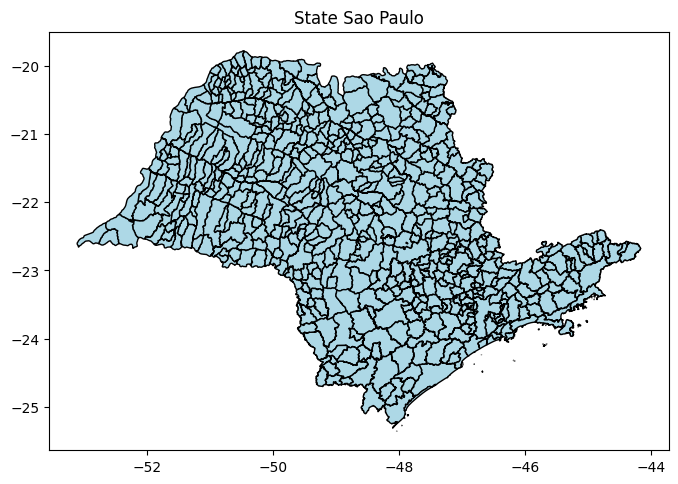

In [301]:
gdf_sp = read_municipality(code_muni="SP", year=2021)
codes_sp = gdf_sp['code_muni'].astype(int).astype(str).tolist()
# Plot
gdf_sp.plot(figsize=(8, 8), edgecolor="black", facecolor="lightblue")
plt.title("State Sao Paulo")
plt.show()

In [339]:
all_data = []
y_start= 2021
y_end = 2025
for geocode in tqdm(codes_sp, desc="Downloading"):
    try:
        df = data_donwload(geocode, y_start=y_start, y_end=y_end)
        df['ibge'] = geocode
        all_data.append(df)
    except Exception as e:
        print(f"Failed for {geocode}: {e}")
    time.sleep(0.1)

data_sp = pd.concat(all_data)
data_sp.head()

del all_data
gc.collect()

Downloading: 100%|██████████| 645/645 [13:30<00:00,  1.26s/it]


0

In [340]:
data_sp.columns

Index(['data_iniSE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos',
       'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo',
       'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao',
       'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov',
       'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf',
       'notif_accum_year', 'ibge'],
      dtype='object')

In [346]:
data_sp2 = data_sp[['data_iniSE', 'ibge', 'nivel', 'casos', 'umidmed', 'tempmed', 'pop']]
data_sp2

,data_iniSE,ibge,nivel,casos,umidmed,tempmed,pop
SE,,,,,,,
202537,2025-09-07,3500105,1,15,41.283775,26.103950,34357.0
202536,2025-08-31,3500105,1,22,40.892229,25.794371,34357.0
202535,2025-08-24,3500105,1,10,56.847486,22.895343,34357.0
202534,2025-08-17,3500105,1,12,41.691471,25.340443,34357.0
202533,2025-08-10,3500105,1,7,45.644986,17.593957,34357.0
...,...,...,...,...,...,...,...
202105,2021-01-31,3557303,2,1,73.270633,25.268978,11407.0
202104,2021-01-24,3557303,1,1,73.489036,24.600140,11407.0
202103,2021-01-17,3557303,1,1,73.088123,25.179277,11407.0


In [347]:
summary = data_sp2.groupby('data_iniSE').agg({"casos": "sum",
                                              "tempmed": "mean",
                                              "umidmed": "mean",
                                              "pop" : "sum"
                                        }).reset_index()

summary = summary[summary['data_iniSE'] <= '2025-07-01']
summary['data_iniSE'] = pd.to_datetime(summary['data_iniSE'])
summary['casos_100k'] = summary['casos'] / summary['pop'] * 100000
summary

,data_iniSE,casos,tempmed,umidmed,pop,casos_100k
0,2021-01-03,3784,25.482833,69.558708,46289333.0,8.174670
1,2021-01-10,3968,24.934893,77.908664,46289333.0,8.572169
2,2021-01-17,4811,25.741954,69.843846,46289333.0,10.393323
3,2021-01-24,5531,25.518964,69.127408,46289333.0,11.948757
4,2021-01-31,7201,25.356603,71.282783,46289333.0,15.556500
...,...,...,...,...,...,...
230,2025-06-01,28748,19.786709,76.270582,46024937.0,62.461791
231,2025-06-08,19848,16.823854,75.386224,46024937.0,43.124448
232,2025-06-15,15510,19.075310,66.537811,46024937.0,33.699123
233,2025-06-22,12727,18.019178,69.653567,46024937.0,27.652401


In [348]:
summary.isna().sum()

,0
data_iniSE,0
casos,0
tempmed,0
umidmed,0
pop,0
casos_100k,0


# Sao Paolo

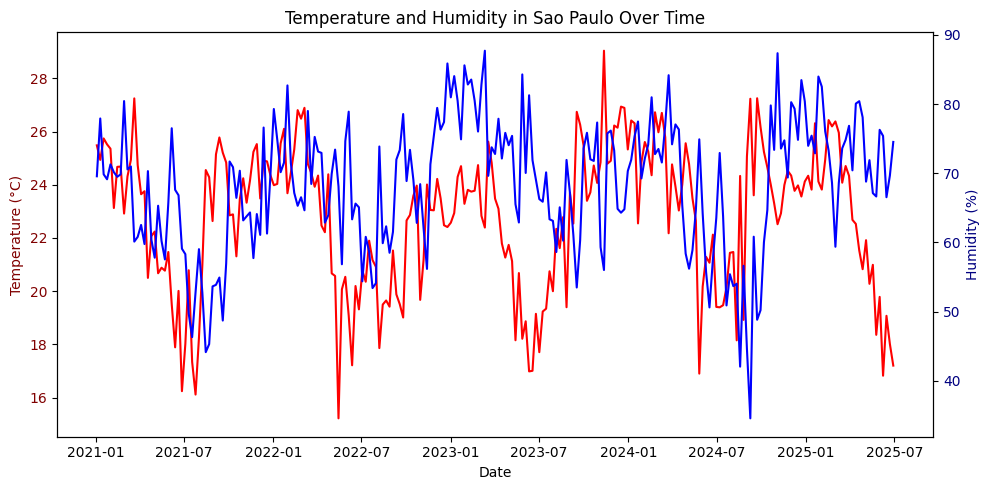

In [349]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.plot(summary['data_iniSE'], summary['tempmed'], color='red', label='Temp (°C)')
ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (°C)", color='maroon')
ax1.tick_params(axis='y', labelcolor='maroon')

ax2 = ax1.twinx()
ax2.plot(summary['data_iniSE'], summary['umidmed'], color='blue', label='Humidity (%)')
ax2.set_ylabel("Humidity (%)", color='navy')
ax2.tick_params(axis='y', labelcolor='navy')

plt.title("Temperature and Humidity in Sao Paulo Over Time")

fig.tight_layout()
plt.show()

In [350]:
def plot_int(df_gen, df_casos, region):

    df_gen = df_gen.sort_values('time')
    df_casos = df_casos.sort_values('data_iniSE')

    # PLot serotype
    fig = px.area(
        df_gen,
        x='time', y='percent', color='var',
        labels={'time':'Date', 'percent':'Proportion', 'var':'Serotype'},
        title=f'Serotype Progression and Dengue Incidence in {region}'
    )

    fig.update_traces(mode='lines+markers', connectgaps=False)

    fig.add_trace(
        go.Scatter(
            x=df_casos['data_iniSE'],
            y=df_casos['casos_100k'],
            name="Incidence",
            mode="lines+markers",
            line=dict(color="black"),
            yaxis="y2"
        )
    )

    # fig.update_xaxes(
    #     dtick="M1",
    #     tickformat="%b\n%Y",
    #     rangeslider_visible=True,
    #     rangeslider=dict(bgcolor='grey')
    # )

    fig.update_layout(
        yaxis=dict(title="Proportion", tickformat=".0%", range=[0, 1]),
        yaxis2=dict(title="Incidence per 100k pop", overlaying="y", side="right"),
        xaxis=dict(range=[df_gen['time'].min(), df_gen['time'].max()]),
        legend_title_text=''
    )

    fig.show()


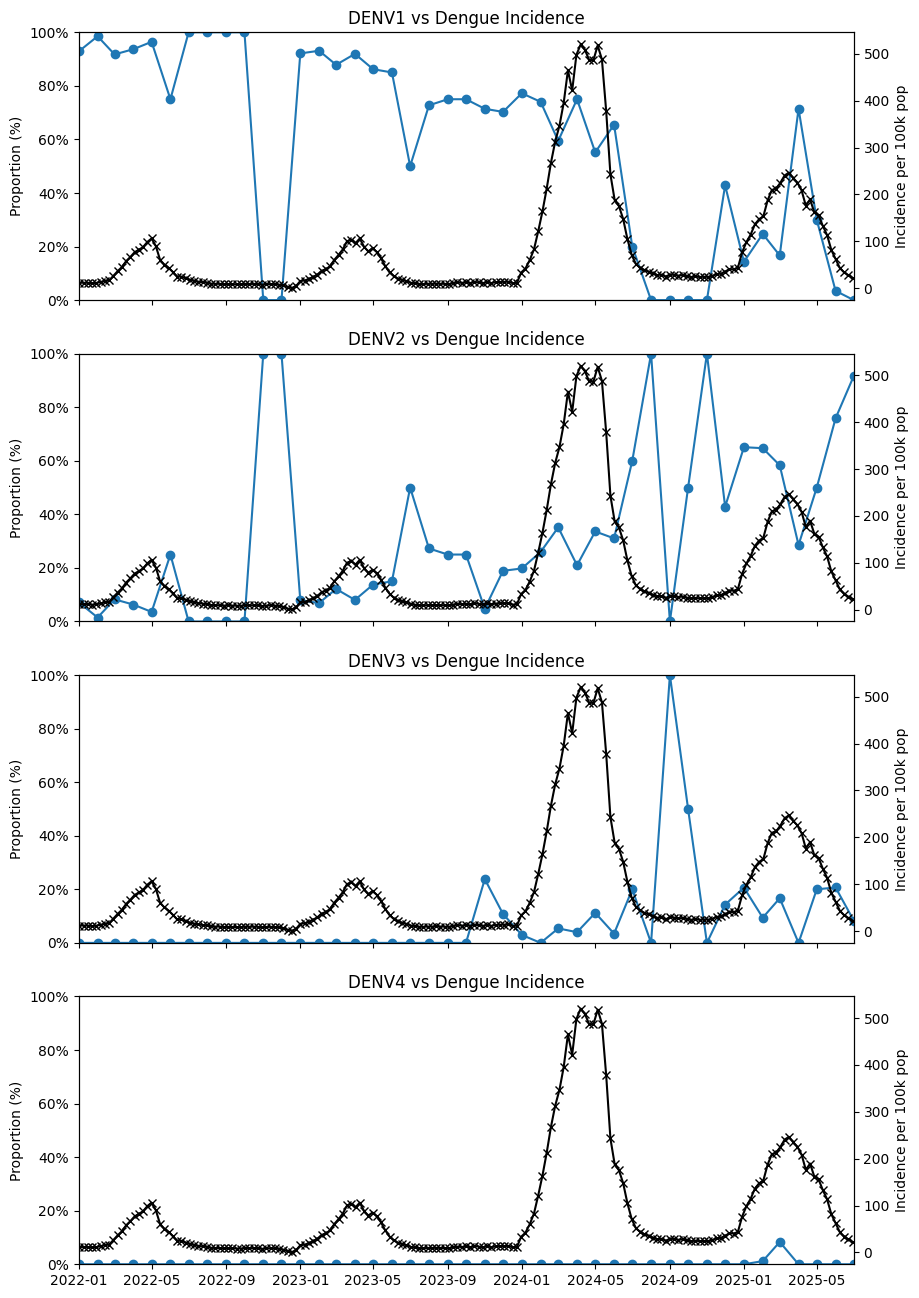

In [353]:
df_gen = sero_df1
df_casos = summary

start = (df_gen["time"].min())
end = (df_gen["time"].max())

df_gen['percent'] = df_gen['percent'].astype(float)
vvar = df_gen['var'].unique()
n = len(vvar)

fig, axes = plt.subplots(n, 1, figsize=(10, 4*n), sharex=True)
if n == 1:
    axes = [axes]

for i, vv in enumerate(vvar):

  ax = axes[i]
  sub = df_gen[df_gen['var'] == vv]

  ax.plot(sub['time'], sub['percent'], marker='o', label=f"{vv}", color="tab:blue")
  ax.set_ylabel("Proportion (%)")
  ax.set_ylim(0, 1)
  ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{y:.0%}"))

  ax2 = ax.twinx()
  ax2.plot(df_casos['data_iniSE'], df_casos['casos_100k'], marker='x', color="black", label="Incidence per 100k pop")
  ax2.set_ylabel('Incidence per 100k pop')

  ax.set_title(f"{vv} vs Dengue Incidence")
  ax.set_xlim(start, end)


In [354]:
plot_int(df_gen=sero_df1, df_casos=summary ,region='Sao Paulo')

## Prototype 1:
- Only Sao Paulo (as a first testing subject)
- Check the lags on the weather data and adjust the temperature and humidity based on the average on the past lags
- Manually impute data on the serotype (for experiment)
- Do 2 types of GLM


1.   Expected number of the serotypes
2.   List item


---



the past 12 weeks of temperature correlates the strongest with the incidence
the past 18 weeks of humidities correlates the strongest with the incidence


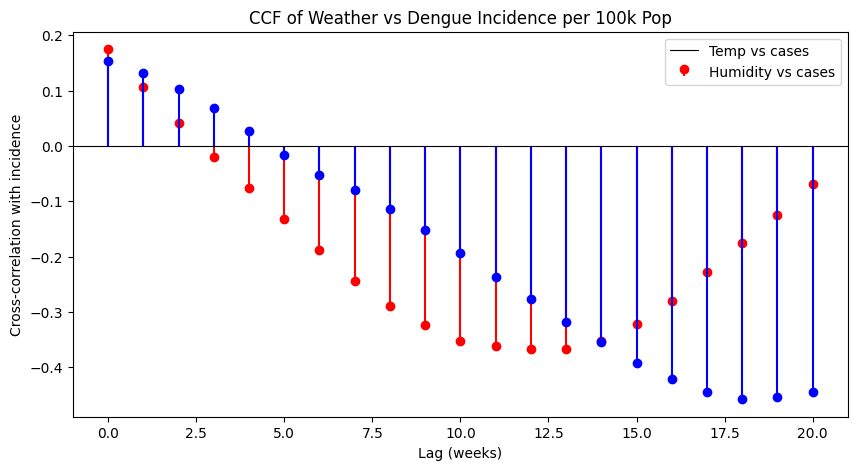

In [355]:
# Adjust the weather data based on the lag
df_ccf = summary.dropna(subset=["casos_100k","tempmed","umidmed"]).copy()

# Normalize
for c in ["casos","tempmed","umidmed"]:
    df_ccf[c+"_z"] = (df_ccf[c] - df_ccf[c].mean()) / df_ccf[c].std()

# CCF calculation
max_lag = 20
ccf_temp = ccf(df_ccf["tempmed_z"], df_ccf["casos_z"])[:max_lag+1]
ccf_humid = ccf(df_ccf["umidmed_z"], df_ccf["casos_z"])[:max_lag+1]

lags = np.arange(0, max_lag+1)
best_lag_temp = lags[np.argmax(abs(ccf_temp))]
best_lag_humid = lags[np.argmax(abs(ccf_humid))]
print(f"the past {best_lag_temp} weeks of temperature correlates the strongest with the incidence")
print(f"the past {best_lag_humid} weeks of humidities correlates the strongest with the incidence")

lags = np.arange(0, max_lag+1)
plt.figure(figsize=(10,5))
plt.stem(lags, ccf_temp, linefmt="r-", markerfmt="ro", basefmt=" ")
plt.stem(lags, ccf_humid, linefmt="b-", markerfmt="bo", basefmt=" ")
plt.axhline(0, color="black", linewidth=0.8)
plt.xlabel("Lag (weeks)")
plt.ylabel("Cross-correlation with incidence")
plt.title("CCF of Weather vs Dengue Incidence per 100k Pop")
plt.legend(["Temp vs cases","Humidity vs cases"])
plt.show()

In [360]:
sum2 = summary.copy()

sum2["temp_lag"] = sum2["tempmed"].shift(best_lag_temp)
sum2["hum_lag"]  = sum2["umidmed"].shift(best_lag_humid)
sum2 = sum2[sum2["data_iniSE"] >= "2022-01-01"].reset_index(drop=True)

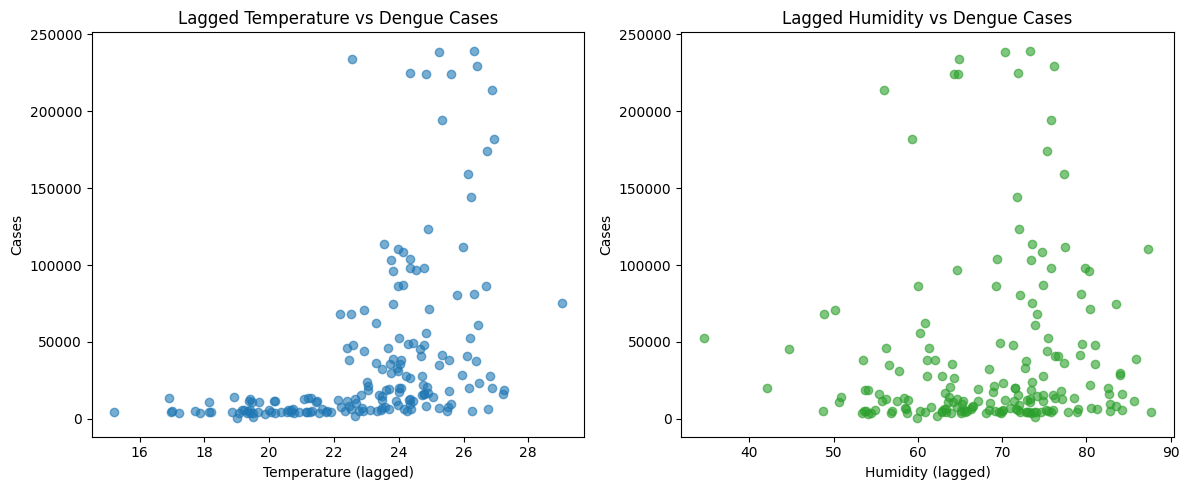

In [422]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# temp vs cases
axes[0].scatter(sum2["temp_lag"], sum2["casos"], alpha=0.6, color="tab:blue")
axes[0].set_xlabel("Temperature (lagged)")
axes[0].set_ylabel("Cases")
axes[0].set_title("Lagged Temperature vs Dengue Cases")

# humidity vs cases
axes[1].scatter(sum2["hum_lag"], sum2["casos"], alpha=0.6, color="tab:green")
axes[1].set_xlabel("Humidity (lagged)")
axes[1].set_ylabel("Cases")
axes[1].set_title("Lagged Humidity vs Dengue Cases")

plt.tight_layout()
plt.show()

In [362]:
# Manually interpolate the odd periods
# oct 2022 - jan 2023 hole and 2024

mask1 = ((sero_df1['time'] >= '2022-10-01') &
        (sero_df1['time'] <= '2023-01-01') &
        (sero_df1['var'] == 'DENV1'))

s = sero_df1.loc[mask1, 'percent'].copy()
s[s == 0] = np.nan
s_interp = s.interpolate(method="linear")

sero_df1_interp = sero_df1.copy()
sero_df1_interp.loc[mask1, 'percent'] = s_interp


mask2 = ((sero_df1['time'] > '2022-10-01') &
        (sero_df1['time'] < '2023-01-01') &
        (sero_df1['var'] == 'DENV2'))

sero_df1_interp.loc[mask2, 'percent'] = 1-s_interp


mask3 = ((sero_df1['time'] >= '2024-07-01') &
        (sero_df1['time'] <= '2024-10-01') &
        (sero_df1['var'] == 'DENV2'))

s = sero_df1.loc[mask3]['percent'].copy()

s.iloc[1:3] = np.nan
s_interp = s.interpolate(method="linear")

sero_df1_interp.loc[mask3, 'percent'] = s_interp


mask4 = ((sero_df1['time'] >= '2024-07-01') &
        (sero_df1['time'] <= '2024-10-01') &
        (sero_df1['var'] == 'DENV3'))

s2 = sero_df1.loc[mask4]['percent'].copy()

s2.iloc[1:3] = np.nan
s_interp2 = s2.interpolate(method="linear")

sero_df1_interp.loc[mask4, 'percent'] = s_interp2

mask5 = ((sero_df1['time'] > '2024-07-01') &
        (sero_df1['time'] < '2024-10-01') &
        (sero_df1['var'] == 'DENV1'))

s3 = sero_df1.loc[mask5]['percent'].copy()
sero_df1_interp.loc[mask5, 'percent'] = 1-s_interp-s_interp2

mask6 = ((sero_df1['time'] >= '2024-10-01') &
        (sero_df1['time'] <= '2024-12-01') &
        (sero_df1['var'] == 'DENV3'))

s4 = sero_df1.loc[mask6]['percent'].copy()
s4[s4 == 0] = np.nan
s_interp3 = s4.interpolate(method="linear")
sero_df1_interp.loc[mask6, 'percent'] = s_interp3

mask7 = ((sero_df1['time'] > '2024-10-01') &
        (sero_df1['time'] < '2024-12-01') &
        (sero_df1['var'] == 'DENV2'))

s4 = sero_df1.loc[mask7]['percent'].copy()
sero_df1_interp.loc[mask7, 'percent'] = 1-s_interp3

In [363]:
plot_int(df_gen=sero_df1_interp, df_casos=summary ,region='Sao Paulo')

# Calculate expected number of serotype

In [441]:
# Still need to account for rounding errors
sum2["year"] = sum2["data_iniSE"].dt.year
sum2["month"] = sum2["data_iniSE"].dt.month

sero_wide = (sero_df1_interp
             .pivot(index="time", columns="var", values="percent")
             .reset_index())

sero = list(sero_df1['var'].unique())

sero_wide["year"] = sero_wide["time"].dt.year
sero_wide["month"] = sero_wide["time"].dt.month

comb1 = sum2.merge(sero_wide[["year","month"]+sero],  on=["year","month"], how="left")

for s in sero:
    comb1[f"{s}_exp"] = comb1["casos_100k"] * comb1[s]


In [442]:
comb1.head(5)

,data_iniSE,casos,tempmed,umidmed,pop,casos_100k,temp_lag,hum_lag,year,month,DENV1,DENV2,DENV3,DENV4,DENV1_exp,DENV2_exp,DENV3_exp,DENV4_exp
0,2022-01-02,5337,23.985126,79.278864,46289333.0,11.529654,22.887755,53.656435,2022,1,0.9286,0.0714,0.0,0.0,10.706437,0.823217,0.0,0.0
1,2022-01-09,5354,24.032444,74.886436,46289333.0,11.566380,21.310627,53.878900,2022,1,0.9286,0.0714,0.0,0.0,10.740540,0.825840,0.0,0.0
2,2022-01-16,5363,25.556710,70.152000,46289333.0,11.585823,23.454354,54.935285,2022,1,0.9286,0.0714,0.0,0.0,10.758595,0.827228,0.0,0.0
3,2022-01-23,4846,26.104035,71.548899,46289333.0,10.468935,24.243895,48.722468,2022,1,0.9286,0.0714,0.0,0.0,9.721453,0.747482,0.0,0.0
4,2022-01-30,5229,23.682860,82.683783,46289333.0,11.296339,23.327322,56.988051,2022,1,0.9286,0.0714,0.0,0.0,10.489780,0.806559,0.0,0.0


In [446]:
cols_to_scale = ["temp_lag", "hum_lag", "DENV1_exp", "DENV2_exp", "DENV3_exp", "DENV4_exp"]
scaler = StandardScaler()
comb1_norm = comb1.copy()
comb1_norm[cols_to_scale] = scaler.fit_transform(comb1_norm[cols_to_scale])

In [487]:
# GLM simplest form
formula = """
casos_100k  ~ bs(DENV1_exp, df=3) + bs(DENV3_exp, df=3) + bs(DENV4_exp, df=3)
        + bs(temp_lag, df=3) + bs(hum_lag, df=3)
        + C(year)
"""

mod1 = smf.glm(
    formula=formula,
    data=comb1_norm,
    family=sm.families.NegativeBinomial(alpha=1)
)
res1 = mod1.fit()
print(res1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             casos_100k   No. Observations:                  183
Model:                            GLM   Df Residuals:                      164
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -859.11
Date:                Fri, 19 Sep 2025   Deviance:                       10.230
Time:                        19:06:12   Pearson chi2:                     8.34
No. Iterations:                     9   Pseudo R-squ. (CS):             0.7772
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

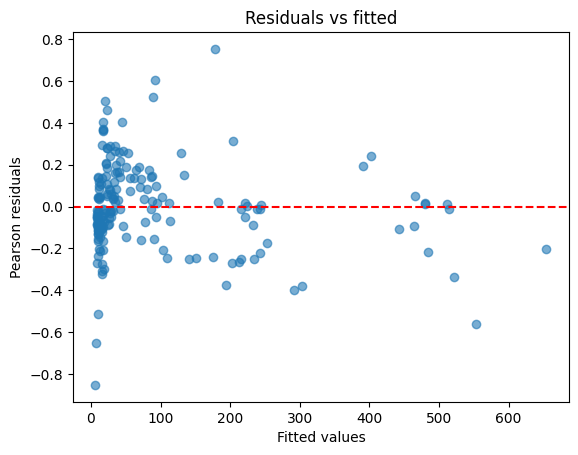

In [488]:
# fitted vs residuals
df_resid = pd.DataFrame({
    "fitted": res1.fittedvalues,
    "pearson_resid": res1.resid_pearson,
    "deviance_resid": res1.resid_deviance
})

plt.scatter(df_resid["fitted"], df_resid["pearson_resid"], alpha=0.6)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Pearson residuals")
plt.title("Residuals vs fitted")
plt.show()